# Week 1 – Feature Matching Deliverable


In [2]:
from pathlib import Path
import sys

import itertools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


PROJECT_ROOT = Path('..').resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

#Global Varibales Setting here
ASSETS_DIR = PROJECT_ROOT / 'assets'
OUTPUT_DIR = PROJECT_ROOT / 'outputs' / 'feature_matches'
DETECTOR = 'ORB'
RATIO_THRESH = 0.70
PAIR_TOKENS = None  
MAX_PREVIEW = None 

ASSETS_DIR, OUTPUT_DIR, DETECTOR, RATIO_THRESH

from src.feature_matching_pipeline import run_pipeline

In [3]:
summaries = run_pipeline(
    image_dir=ASSETS_DIR,
    output_dir=OUTPUT_DIR,
    detector=DETECTOR,
    ratio_thresh=RATIO_THRESH,
    pair_tokens=PAIR_TOKENS,
)
print(f'Processed {len(summaries)} image pair(s).')
for summary in summaries:
    print(
        f'{summary.image_a.name} vs {summary.image_b.name}: '
        f'{summary.filtered_matches}/{summary.raw_matches} filtered matches'
    )

Processed 13 image pair(s).
img_1.jpeg vs img_2.jpeg: 329/4000 filtered matches
img_2.jpeg vs img_3.jpeg: 293/4000 filtered matches
img_3.jpeg vs img_4.jpeg: 476/4000 filtered matches
img_4.jpeg vs img_5.jpeg: 284/4000 filtered matches
img_5.jpeg vs img_6.jpeg: 426/4000 filtered matches
img_6.jpeg vs img_7.jpeg: 259/4000 filtered matches
img_7.jpeg vs img_8.jpeg: 455/4000 filtered matches
img_8.jpeg vs img_9.jpeg: 258/4000 filtered matches
img_9.jpeg vs img_10.jpeg: 150/4000 filtered matches
img_10.jpeg vs img_11.jpeg: 81/4000 filtered matches
img_11.jpeg vs img_12.jpeg: 280/4000 filtered matches
img_12.jpeg vs img_13.jpeg: 282/4000 filtered matches
img_13.jpeg vs img_14.jpeg: 236/4000 filtered matches


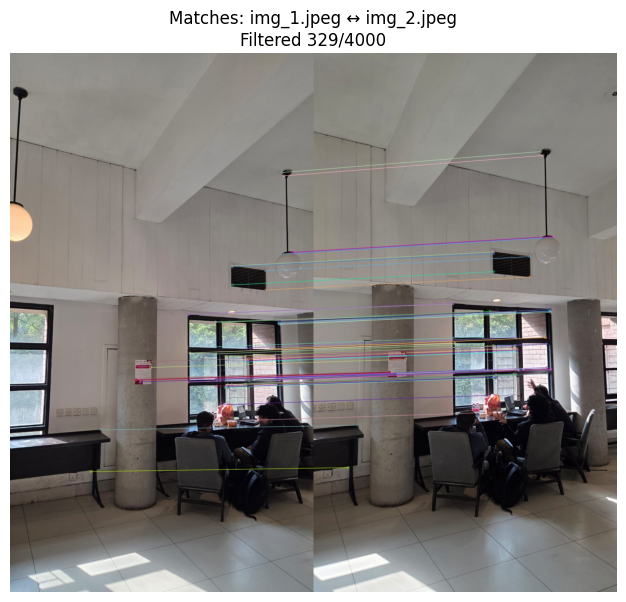

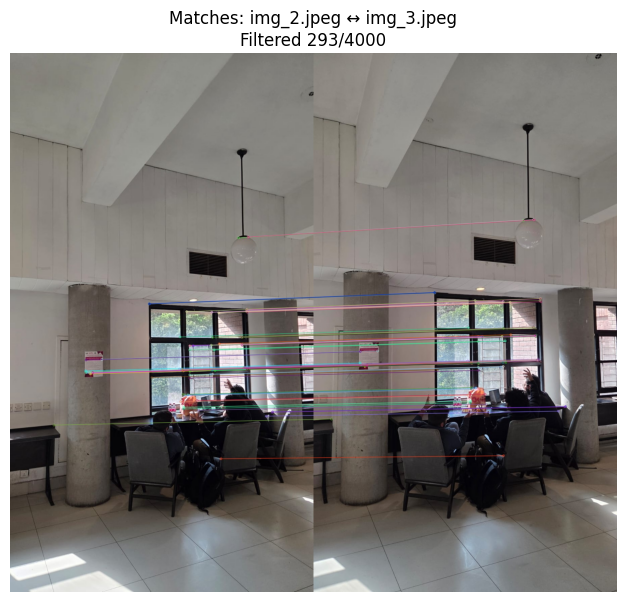

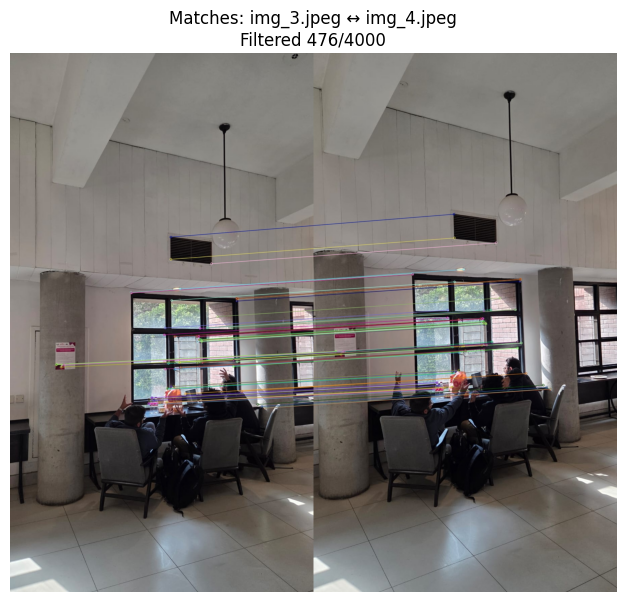

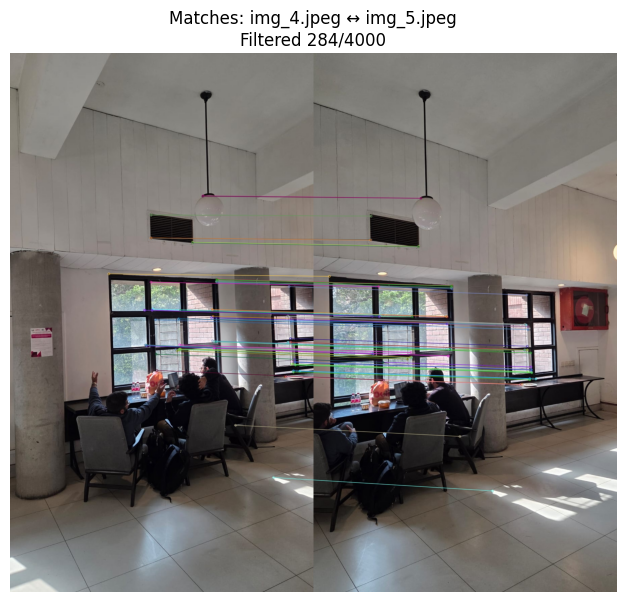

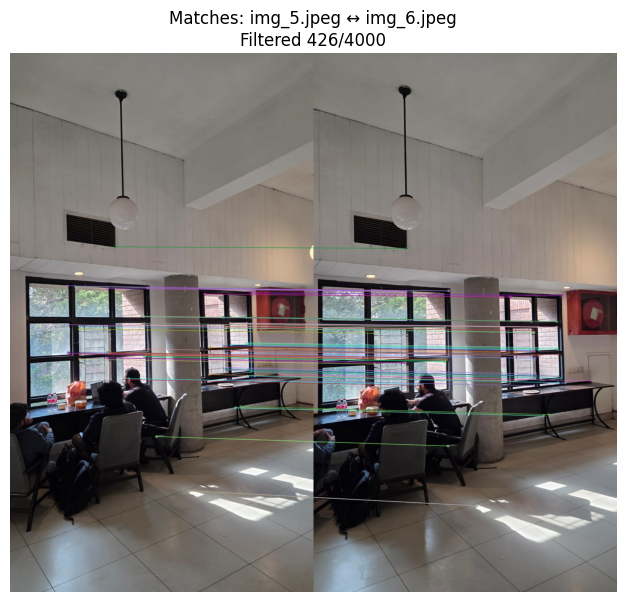

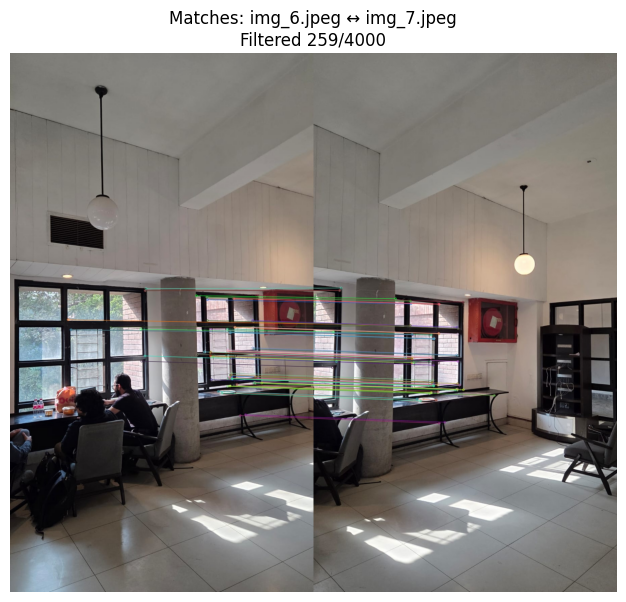

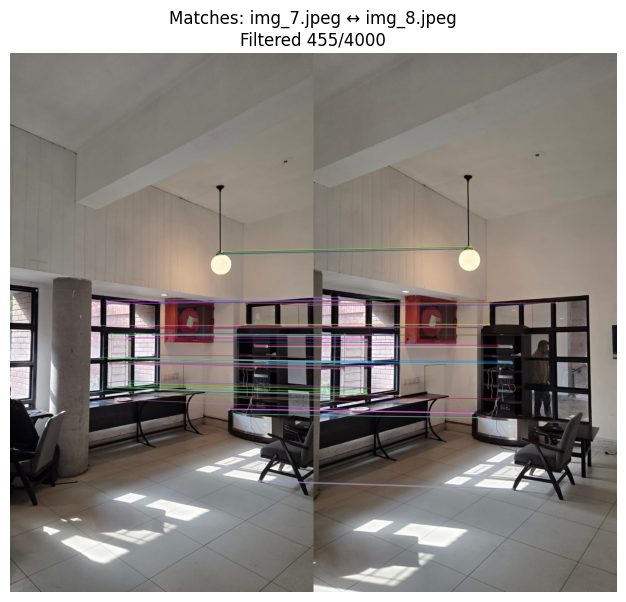

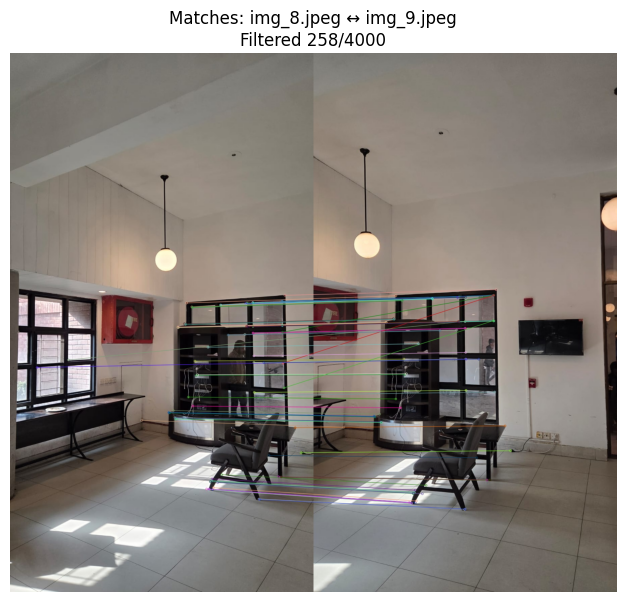

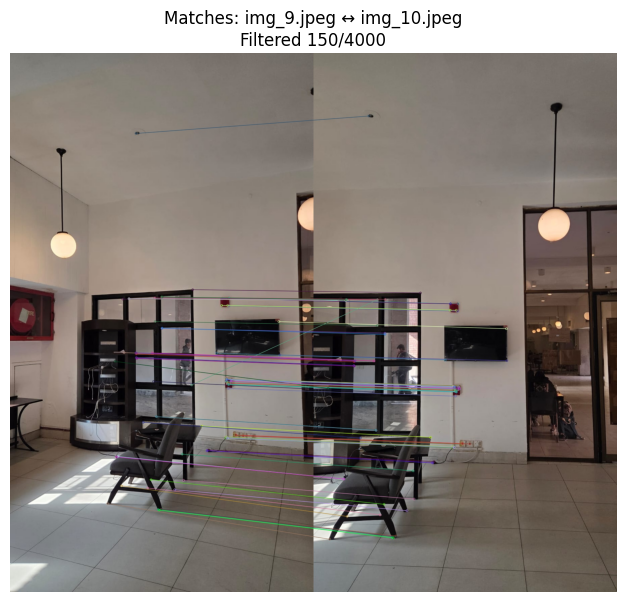

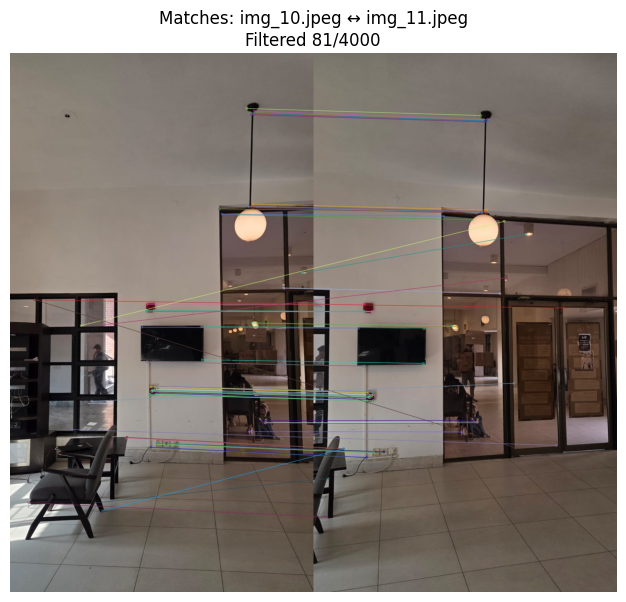

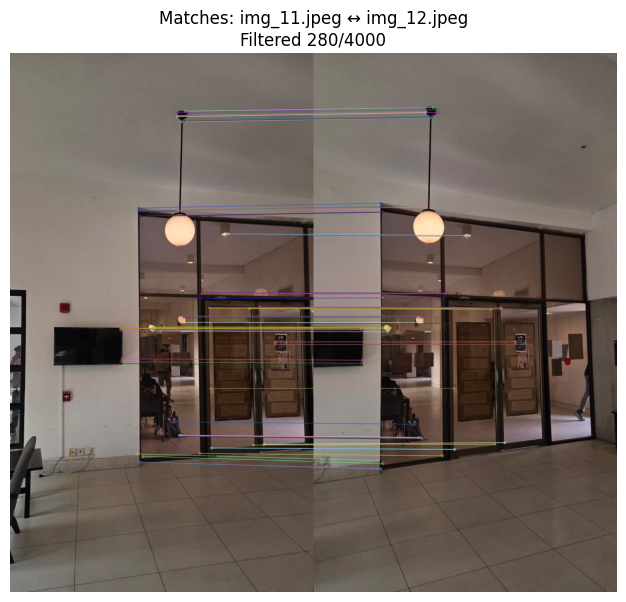

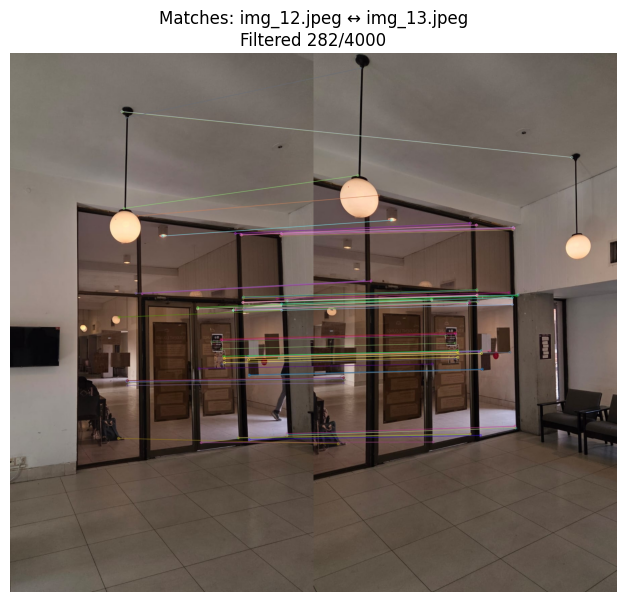

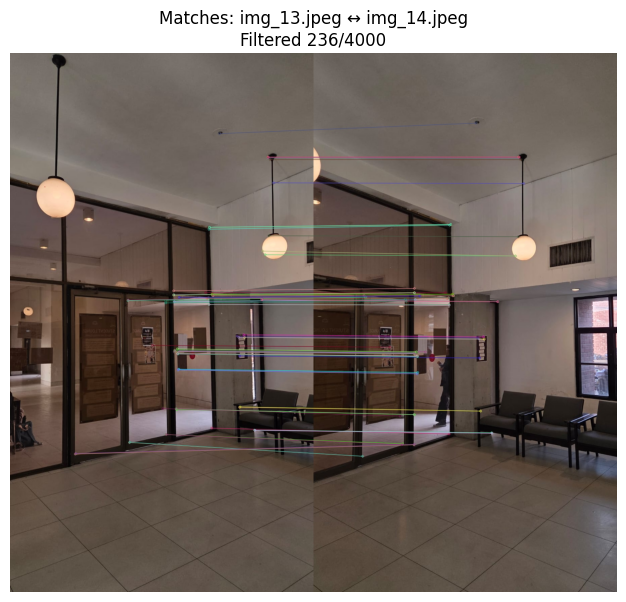

In [4]:
if summaries:
    preview_iter = summaries

    if isinstance(MAX_PREVIEW, int):
        preview_iter = itertools.islice(summaries, MAX_PREVIEW)
    
    for summary in preview_iter:
        image = mpimg.imread(summary.output_path)
        plt.figure(figsize=(14, 7))
        plt.imshow(image)
        plt.title(
            f"Matches: {summary.image_a.name} \u2194 {summary.image_b.name}\n"
            f"Filtered {summary.filtered_matches}/{summary.raw_matches}"
        )
        plt.axis('off')
        plt.show()
else:
    print('No images in assets directory.')


In [10]:
# --- Two-view reconstruction: essential matrix -> pose -> triangulated point cloud (.ply) ---
import sys
from pathlib import Path
from typing import Optional
import cv2
import numpy as np
from src.feature_matching_pipeline import collect_image_paths, create_detector


PROJECT_ROOT = Path("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))
default_assets = PROJECT_ROOT / "assets"

# Fall back to defaults if this cell is run standalone.
if "ASSETS_DIR" not in globals():
    ASSETS_DIR = default_assets

recon_detector = "SIFT"  # using SIFT
recon_ratio = 0.70
preferred_pair = ("img_1.jpeg", "img_5.jpeg")
ply_output = PROJECT_ROOT / "outputs" / "reconstruction" / "two_view_points.ply"


def choose_image_pair(asset_dir: Path, preferred_names):
    '''Pick the two images to reconstruct, defaulting to the first two in order.'''
    images = collect_image_paths(asset_dir)
    lookup = {path.name: path for path in images}
    if all(name in lookup for name in preferred_names):
        return lookup[preferred_names[0]], lookup[preferred_names[1]]
    return images[0], images[1]


def approximate_intrinsics(image: np.ndarray) -> np.ndarray:
    '''Approximate K with f = image width and principal point at the center.'''
    h, w = image.shape[:2]
    f = float(w)
    cx, cy = w / 2.0, h / 2.0
    return np.array([[f, 0.0, cx], [0.0, f, cy], [0.0, 0.0, 1.0]], dtype=np.float64)


def detect_and_match_points(detector_name, img_a, img_b, ratio):
    '''Detect keypoints, compute descriptors, and apply Lowe's ratio test.'''
    detector = create_detector(detector_name)
    gray_a = cv2.cvtColor(img_a, cv2.COLOR_BGR2GRAY)
    gray_b = cv2.cvtColor(img_b, cv2.COLOR_BGR2GRAY)
    kps_a, des_a = detector.detectAndCompute(gray_a, None)
    kps_b, des_b = detector.detectAndCompute(gray_b, None)
    if des_a is None or des_b is None:
        raise RuntimeError("Could not compute descriptors; check image quality.")
    norm = cv2.NORM_HAMMING if des_a.dtype == np.uint8 else cv2.NORM_L2
    matcher = cv2.BFMatcher(norm)
    knn = matcher.knnMatch(des_a, des_b, k=2)
    good = [m for m, n in knn if n is not None and m.distance < ratio * n.distance]
    good.sort(key=lambda m: m.distance)
    pts_a = np.float64([kps_a[m.queryIdx].pt for m in good])
    pts_b = np.float64([kps_b[m.trainIdx].pt for m in good])
    return good, pts_a, pts_b, kps_a, kps_b


def triangulate_with_pose(R, t, K, pts_a, pts_b):
    '''Triangulate normalized points for a given pose and perform a cheirality check.'''
    proj_0 = K @ np.hstack([np.eye(3), np.zeros((3, 1))])
    proj_1 = K @ np.hstack([R, t])
    pts1_norm = cv2.undistortPoints(pts_a.reshape(-1, 1, 2), K, None).reshape(-1, 2).T
    pts2_norm = cv2.undistortPoints(pts_b.reshape(-1, 1, 2), K, None).reshape(-1, 2).T
    hom = cv2.triangulatePoints(proj_0, proj_1, pts1_norm, pts2_norm)
    points_3d = (hom[:3] / hom[3]).T
    points_cam1 = (R @ points_3d.T + t).T
    valid_mask = (points_3d[:, 2] > 0) & (points_cam1[:, 2] > 0)
    return points_3d, valid_mask


def save_ply(path: Path, points: np.ndarray, colors: Optional[np.ndarray] = None) -> str:
    '''Write a minimal ASCII PLY for viewing the sparse reconstruction.'''
    path.parent.mkdir(parents=True, exist_ok=True)
    finite = np.isfinite(points).all(axis=1)
    points = points[finite]
    if colors is not None:
        colors = colors[finite]
    with open(path, "w") as f:
        f.write("ply\nformat ascii 1.0\n")
        f.write(f"element vertex {len(points)}\n")
        f.write("property float x\nproperty float y\nproperty float z\n")
        if colors is not None:
            f.write("property uchar red\nproperty uchar green\nproperty uchar blue\n")
        f.write("end_header\n")
        for i, p in enumerate(points):
            if colors is not None:
                r, g, b = colors[i]
                f.write(
                    f"{p[0]:.6f} {p[1]:.6f} {p[2]:.6f} {int(r)} {int(g)} {int(b)}\n"
                )
            else:
                f.write(f"{p[0]:.6f} {p[1]:.6f} {p[2]:.6f}\n")
    return str(path)


# 1) Select the stereo pair that has translation / parallax.
image_a_path, image_b_path = choose_image_pair(ASSETS_DIR, preferred_pair)
image_a = cv2.imread(str(image_a_path))
image_b = cv2.imread(str(image_b_path))
assert image_a is not None and image_b is not None, "Image files could not be loaded."

# 2) Camera intrinsics approximation with principal point at center and f = image width.
K = approximate_intrinsics(image_a)

# 3) Detect + match with ratio test.
matches, pts_a, pts_b, kps_a, kps_b = detect_and_match_points(
    recon_detector, image_a, image_b, recon_ratio
)
print(f"Matched {len(matches)} features using {recon_detector} (ratio={recon_ratio}).")
if len(matches) < 8:
    raise RuntimeError("Not enough matches to estimate the Essential matrix.")

# 4) Estimate E with RANSAC.
E, ransac_mask = cv2.findEssentialMat(
    pts_a, pts_b, K, method=cv2.RANSAC, prob=0.999, threshold=1.0
)
if E is None:
    raise RuntimeError("cv2.findEssentialMat failed.")
if E.ndim > 2:
    E = E[:, :, 0]
_, recovered_R, recovered_t, ransac_mask = cv2.recoverPose(
    E, pts_a, pts_b, K, mask=ransac_mask
)
inlier_mask = ransac_mask.ravel().astype(bool)
pts_a_in = pts_a[inlier_mask]
pts_b_in = pts_b[inlier_mask]
print(f"Essential matrix inliers: {inlier_mask.sum()}")

# 5) Build four pose hypotheses and run cheirality check via triangulation.
R1, R2, t_unit = cv2.decomposeEssentialMat(E)
pose_candidates = [
    ("R1,+t", R1, t_unit),
    ("R1,-t", R1, -t_unit),
    ("R2,+t", R2, t_unit),
    ("R2,-t", R2, -t_unit),
]
cheirality_counts = []
triangulated = []

for label, R_cand, t_cand in pose_candidates:
    cloud, valid_mask = triangulate_with_pose(R_cand, t_cand, K, pts_a_in, pts_b_in)
    count = int(valid_mask.sum())
    cheirality_counts.append(count)
    triangulated.append((cloud, valid_mask))
    print(f"{label}: {count} points with positive depth")

best_idx = int(np.argmax(cheirality_counts))
best_label, R_best, t_best = pose_candidates[best_idx]
best_cloud, best_valid = triangulated[best_idx]
best_points = best_cloud[best_valid]
print(f"Selected pose {best_label} (cheirality max).")

# 6) Colorize points from view A and write .ply.
pixel_coords = np.round(pts_a_in[best_valid]).astype(int)
pixel_coords[:, 0] = np.clip(pixel_coords[:, 0], 0, image_a.shape[1] - 1)
pixel_coords[:, 1] = np.clip(pixel_coords[:, 1], 0, image_a.shape[0] - 1)
colors_rgb = image_a[pixel_coords[:, 1], pixel_coords[:, 0], ::-1]  # BGR -> RGB
ply_path = save_ply(ply_output, best_points, colors_rgb)
print(f"Saved {len(best_points)} triangulated points to {ply_path}")
print(f"Recovered pose (R,t):\nR =\n{R_best}\nt =\n{t_best.reshape(-1)}")


Matched 126 features using SIFT (ratio=0.7).
Essential matrix inliers: 56
R1,+t: 0 points with positive depth
R1,-t: 0 points with positive depth
R2,+t: 0 points with positive depth
R2,-t: 56 points with positive depth
Selected pose R2,-t (cheirality max).
Saved 56 triangulated points to /Users/muhammadabdullahirfan/Desktop/Uni/Sem_5/CV/project/cv-project/outputs/reconstruction/two_view_points.ply
Recovered pose (R,t):
R =
[[ 0.97707194  0.00949496 -0.21269759]
 [-0.03021416  0.99507819 -0.09437426]
 [ 0.21075466  0.09863692  0.97254986]]
t =
[ 0.78922145 -0.00658715  0.61407337]


In [11]:
# --- Pose / Essential matrix sanity checks ---
import numpy as np

# Prefer the disambiguated pose if available, otherwise fall back to recoverPose output.
try:
    R_used = R_best
    t_used = t_best
except NameError:
    R_used = recovered_R
    t_used = recovered_t


def _skew(v):
    x, y, z = v.ravel()
    return np.array([[0.0, -z, y], [z, 0.0, -x], [-y, x, 0.0]])


def pose_sanity_checks(R, t):
    RtR = R.T @ R
    ortho_err = np.linalg.norm(RtR - np.eye(3))
    detR = np.linalg.det(R)
    t_norm = np.linalg.norm(t)
    print(f"||R^T R - I||_F = {ortho_err:.3e}  det(R) = {detR:.6f}  ||t|| = {t_norm:.6f}")
    return t_norm


def essential_residuals(E, pts1, pts2):
    res = []
    for p1, p2 in zip(pts1, pts2):
        x1 = np.array([p1[0], p1[1], 1.0])
        x2 = np.array([p2[0], p2[1], 1.0])
        res.append(abs(x2 @ E @ x1))
    res = np.array(res)
    print(
        f"Epipolar residuals | mean={res.mean():.4e}, median={np.median(res):.4e}, max={res.max():.4e}"
    )


print("-- Pose checks --")
t_norm = pose_sanity_checks(R_used, t_used)

if 'pts_a_in' in globals() and 'pts_b_in' in globals() and 'K' in globals():
    print("\n-- Essential matrix residuals on inliers --")
    pts1_n = cv2.undistortPoints(pts_a_in.reshape(-1, 1, 2), K, None).reshape(-1, 2)
    pts2_n = cv2.undistortPoints(pts_b_in.reshape(-1, 1, 2), K, None).reshape(-1, 2)
    E_pose = _skew((t_used / t_norm).ravel()) @ R_used
    essential_residuals(E_pose, pts1_n, pts2_n)

if 'best_valid' in globals():
    print(f"\nCheirality: {best_valid.sum()} / {len(best_valid)} points with positive depth")


-- Pose checks --
||R^T R - I||_F = 1.598e-15  det(R) = 1.000000  ||t|| = 1.000000

-- Essential matrix residuals on inliers --
Epipolar residuals | mean=4.6791e-04, median=5.0352e-04, max=1.2012e-03

Cheirality: 56 / 56 points with positive depth
